In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from datetime import datetime, date, time

%matplotlib inline

from my_OIB_functions import *


In [2]:
basedir = '/Users/dporter/Documents/data_local/Antarctica/OIB/'
datadir = 'IGGRV1B'
### Run through each directory
# # directories = [x[0] for x in os.walk(os.path.join(basedir, datadir))]

gravdir = os.path.join(basedir, datadir)
timedir = '2010.11.13'


In [3]:
# def make_oib_csv(gravdir, timedir, make_plots=False):
# -*- coding: utf-8 -*-
# %load_ext autoreload
# %autoreload 2

pd.set_option("display.max_rows", 20)
# pd.set_option("precision",13)
pd.set_option('expand_frame_repr', False)

'''
Specify Directories
'''
# if os.path.isdir('/Volumes/C/'):
#     basedir = '/Volumes/C/data/Antarctic/OIB/ATM/2009_AN_NASA_ATM'
# else:
#     basedir = '/Volumes/BOOTCAMP/data/Antarctic/OIB/ATM/2009_AN_NASA_ATM'
# basedir = '/Users/dporter/Documents/data_local/Antarctica/OIB/'

'\nSpecify Directories\n'

In [4]:
'''
Run functions to read in each data set
'''
### Gravity
grv = {}
grv = importOIBgrav(gravdir, timedir)

### RADAR
# infile = 'IRMCR2_20091031_01'
rad = {}
rad = importOIBrad_all(basedir, timedir)
# rad = importOIBrad(basedir, timedir, infile)

### ATM
if not os.path.exists(os.path.join(basedir, 'ILATM2', timedir, 'ILATM2_'+timedir+'_all.csv')):
    catATM(basedir, timedir)    #only do this if not already done
atm = {}
atm = importOIBatm(basedir, timedir)

['/Users/dporter/Documents/data_local/Antarctica/OIB/IGGRV1B/2010.11.13/IGGRV1B_20101113_11180500_V016.txt']
Reading gravity file: /Users/dporter/Documents/data_local/Antarctica/OIB/IGGRV1B/2010.11.13/IGGRV1B_20101113_11180500_V016.txt.txt
Data file 0 is /Users/dporter/Documents/data_local/Antarctica/OIB/IRMCR2/2010.11.13/IRMCR2_20101113_06.csv


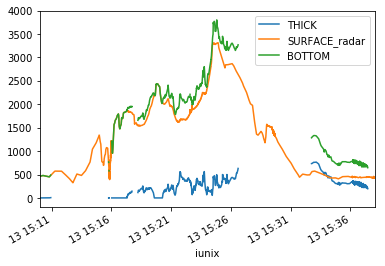

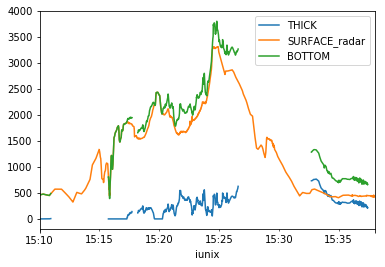

In [74]:
'''
Subsample all to 2 Hz
'''
rad2hz = {}
rad2hz = rad.resample('500L').first().bfill(limit=1)    #.interpolate()  # mean,median,mode???

atm2hz = {}
atm2hz = atm.resample('500L').first().bfill(limit=1)    #.interpolate()  # mean,median,mode???

rad[['THICK', 'SURFACE_radar','BOTTOM']]['2010-11-13T15:10:00':'2010-11-13T15:38:00'].plot(); 
rad2hz[['THICK', 'SURFACE_radar','BOTTOM']]['2010-11-13T15:10:00':'2010-11-13T15:38:00'].plot(); 

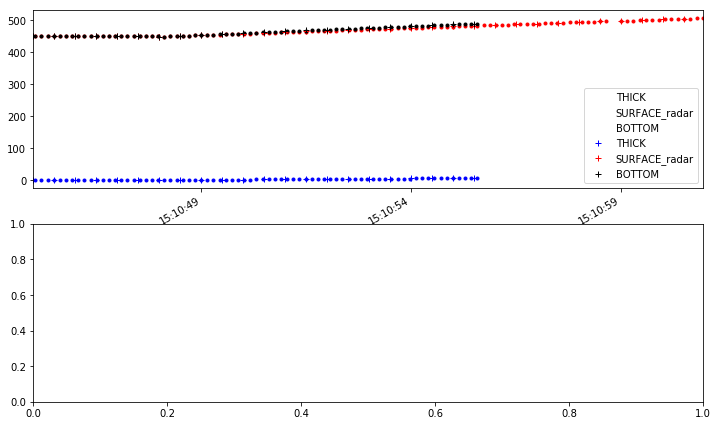

In [75]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
rad[['THICK', 'SURFACE_radar','BOTTOM']]['2010-11-13T15:10:45':'2010-11-13T15:11:00'].plot(ax=axes[0], style=['b.','r.','k.']);
rad2hz[['THICK', 'SURFACE_radar','BOTTOM']]['2010-11-13T15:10:45':'2010-11-13T15:11:00'].plot(ax=axes[0], style=['b+','r+','k+']); 

In [76]:
oidx = rad.index
nidx = pd.date_range(oidx.min(), oidx.max(), freq='500L')
# rad2hz = rad.reindex(oidx.union(nidx)).interpolate('index').reindex(nidx)
# rad2hz.plot(style='.-')
# rad.plot(style='o')

In [77]:
'''
Concatenate into single dataframe
'''
df = {}
# df = pd.concat([grv, rad2hz[['THICK','ELEVATION','FRAME','SURFACE_radar','BOTTOM','QUALITY']]], axis=1,join_axes=[grv.index])
df = pd.concat([grv, rad2hz[['THICK', 'ELEVATION', 'FRAME', 'SURFACE_radar', 'BOTTOM', 'QUALITY']],
                atm2hz[['SURFACE_atm', 'NUMUSED']]], axis=1, join_axes=[grv.index])
# df['DAY'] = df.index.day
# df['HOUR'] = df.index.hour
df['ICEBASE'] = df['ELEVATION'] - df['BOTTOM']
df['TOPOGRAPHY_radar'] = df['ELEVATION'] - df['SURFACE_radar']

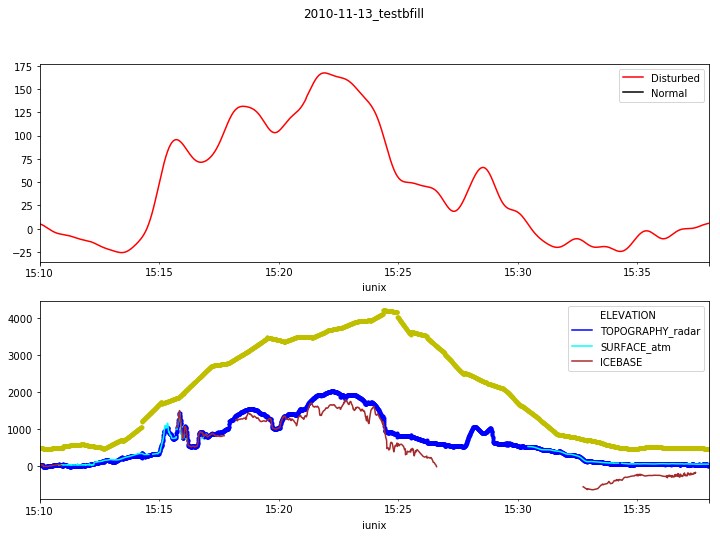

In [79]:
'''
subset one glacier profile by hand
'''
# df_sub = df['2009-10-31 14:10:00':'2009-10-31 14:50:00']
#
# Larsen C
# df_sub = df['2009-11-04 23:00:00':'2009-11-04 23:15:00']
# df_sub = df.loc[df['FRAME'] == 2009110401046]
# df_sub = df.loc[df['FRAME'].isin(['2009110401047','2009110401048'])]
#
# TEST FOR CONTANT THICKNESS
df_sub = df['2010-11-13 15:10:00':'2010-11-13 15:38:00']
# THE ONE BELOW WORKS
# df_sub = df.query('(FRAME <= @subframe+2) & (FRAME >= @subframe-2)')

def oib_lineplot_cust(data, ptitle='test_lineplot', pname='test_lineplot'):
    """
    :param data:
    :param ptitle:
    :param pname:
    :return:
    """
    import matplotlib.pyplot as plt
#     data.loc[data['HYDROAPPX'] < -1500, 'HYDROAPPX'] = np.nan
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    data['FAG070'].where((data['FLTENVIRO'] == 1)).plot(ax=axes[0], legend=True, label='Disturbed', style='r-')
    data['FAG070'].where((data['FLTENVIRO'] == 0)).plot(ax=axes[0], legend=True, label='Normal', style='k-')
    # data['FAG070'].where((data['FLTENVIRO'] == -1)).plot(ax=axes[0], legend=True, label='Missing', style='b-')
    data['ELEVATION'].plot(ax=axes[1], legend=True, style='y.')
    data['TOPOGRAPHY_radar'].plot(ax=axes[1], legend=True, marker=".", color='blue')
#     data['HYDROAPPX'].plot(ax=axes[1], legend=True, color='grey')
    data['SURFACE_atm'].where((data['NUMUSED'] > 77)).plot(ax=axes[1], legend=True, color='cyan')
    data['ICEBASE'].plot(ax=axes[1], legend=True, color='brown')
    plt.suptitle(ptitle, y=0.98)
    plt.savefig(pname, bbox_inches='tight')   # save the figure to file
#     plt.close(fig)
    return

### SUBSET plots
# df_sub['FAG070'].plot()
# fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(16, 12))
# df_sub['FAG070'].plot(ax=axes[0],legend=True);#axes[0,0].set_title('A');
# df_sub['ICEBASE'].plot(ax=axes[1],legend=True);#axes[0,0].set_title('A');
# plt.figure(); df_sub.iloc['2010-11-13 15:05:00':'2010-11-13 15:38:00'].plot(subplots=True,layout=(5,6),figsize=(11, 8));
oib_lineplot_cust(df_sub, \
                  str(df_sub['DATE'][0])[:10] + '_testbfill',\
                  os.path.join('figs', 'test_bfill_lineplot.png'))

In [ ]:
'''
using FX moving average
'''
# # window = 240 for plane maneuvers > 2 minutes
# grv['FX_MA'] = grv['FX'].rolling(window=240, center=True).mean()
# grv_sub = grv.query('(WGSHGT < 3000) & (FX_MA < 70000)')

In [ ]:
'''
Split Dataframe using Gravity quality/presence
'''
print "\n Split Dataframe using Gravity quality/presence"
df['D_gravmask'] = df['FLTENVIRO']
df.loc[df['D_gravmask'] == 0, 'D_gravmask'] = 1
dflist = {}
dflst = [g for _, g in df.groupby((df.D_gravmask.diff() != 0).cumsum())]
for dnum, dname in enumerate(dflst, start=0):
    ### Add LINE channel
    # dflst[dnum].loc[:, 'LINE'] = str(dflst[dnum]['FLT'][0]) + '.' + str(abs(dflst[dnum]['LAT'][0] * 1e3))[:4]
    dflst[dnum].loc[:, 'LINE'] = str(int(dflst[dnum]['UNIX'][0]))
    # mode = dflst[0].mode()['SURFACE_atm'][0]
    mode = min(np.mean(dflst[dnum]['SURFACE_atm'][:10]), np.mean(dflst[dnum]['SURFACE_atm'][10:]))
    if mode < 20:
        clevel = mode
    else:
        clevel = -10
    print 'Mode of ATM is %.2f' % (mode)
    print 'Setting sea-level to %.2f' % (clevel)
    dflst[dnum].loc[:, 'HYDROAPPX'] = (clevel - (dflst[dnum]['SURFACE_atm'] - clevel) * 7.759)  # or SURFACE_atm
    # dflst[dnum].loc[:, 'HYDROAPPX'] = clevel - ((dflst[dnum]['SURFACE_atm'] - clevel) * 7.759)  # or SURFACE_atm
    # (clevel - (((dflst[dnum]['SURFACE_atm'] - clevel) * 7.759))

In [ ]:
### Merge back together
print "\n Merging back together"
df2 = {}
df2 = pd.concat(dflst)
# df_sub = pd.DataFrame.from_dict(map(dict, dflst))
df2.loc[df2['HYDROAPPX'] < -1500, 'HYDROAPPX'] = np.nan

In [ ]:
'''
PLOTS
'''
print "\n Plots"
# plt.figure(); df_sub.plot(subplots=True,layout=(4,8),figsize=(16, 12));
# df['BOTTOM'].where((df['FLTENVIRO'] == 0)).plot(legend=True,label='Good',style ='r-');#axes[0,0].set_title('A');
# df2['BOTTOM'].where((df2['NUMUSED'] > 0)).plot(legend=True,label='Sparse',style ='r-');#axes[0,0].set_title('A');
### Loop through segments
pdir = os.path.join('figs', str(dflst[dnum]['DATE'][0])[:10])
print "Plotting directory is ", pdir
if not os.path.exists(pdir):
    os.makedirs(pdir)
for dnum, dname in enumerate(dflst, start=0):
    if dnum % 2 != 0:
        print "Dnum ", dnum
        if make_plots:
            try:
                oib_lineplot(dflst[dnum], str(dflst[dnum]['DATE'][0])[:10] + '_L' + str(dflst[dnum]['LINE'][0]),
                         os.path.join(pdir, str(dflst[dnum]['LINE'][0])+'_lineplot.png'))
            except:
                print "couldn't lineplot"
            # try:
            #     oib_mapplot_hilite(dflst[dnum]['LONG'], dflst[dnum]['LAT'], dflst[dnum]['FAG070'], df2, 'm',
            #             'FAG070 ' + str(dflst[dnum]['DATE'][0])[:10] + '_L' + str(dflst[dnum]['LINE'][0]),
            #             os.path.join(pdir, str(dflst[dnum]['LINE'][0])+'_mapplot_FAG070.png'))
            # except:
            #     print "couldn't mapplot"

In [ ]:
   
'''
Map
'''
# ### Entire flight
# oib_mapplot(df2['LONG'].where((df2['D_gravmask'] != -1)), df2['LAT'].where((df2['D_gravmask'] != -1)),
#             df2['FLTENVIRO'].where((df2['D_gravmask'] != -1)), 'm', 'FLTENVIRO '+str(df2['DATE'][0])[:10],
#             os.path.join(pdir, str(df2['DATE'][0])[:10]+'_mapplot_FLTENVIRO_ALL.png'))

In [ ]:
'''
Save to CSV
'''
df2.to_csv('data/agg2invert/OIB_ANT_'+str(df2['DATE'][0])[:10]+'.csv')